## Содержание <a class="anchor" id="содержание"></a>

   * [Основная задача](#задача)
   * [Используемые библиотеки](#библиотеки)
   * [Основные настройки агента](#настройки_агента)
   * [Конфигурация диалога и составление датасета](#конфигурация_диалога)
   * [DQN и DDQN агенты](#агент)
   * [Трекер состояния](#трекер)
   * [Формирование запросов к базе данных](#бд)
   * [Настройки взаимодействия с обычным пользователем](#пользователь)
   * [Модуль пользовательской симуляции](#симпользователь)
   * [Модуль контроля ошибок](#ошибка)
   * [Некоторые вспомогательные функции](#дополнения)
   * [Обучение модели](#обучение)
   * [Запуск в тестовом режиме](#тест)
   * [Примеры истории диалогов](#примеры)
   * [Графики обучения DQN и DDQN](#графики)

## Основная задача <a class="anchor" id="задача"></a>

Разработка диалоговой системы, эффективно работающей с окружающей средой (пользователем).

Диалоговая система разработана для бронирования столов в ресторанах Москвы.

## Используемые библиотеки <a class="anchor" id="библиотеки"></a>
* [Вернуться к содержанию](#содержание)

In [2]:
from collections import defaultdict
import random, copy
import numpy as np
import re
import pickle
import json
import copy
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
import math
import time

## Основные настройки агента <a class="anchor" id="настройки_агента"></a>
* [Вернуться к содержанию](#содержание)

```
{
  "db_file_paths": {
    "database": "C:/Users/nkmeo/Course work/Datasets/movie_db.pkl",
    "dict": "C:/Users/nkmeo/Course work/Datasets/movie_dict.pkl",
    "user_goals": "C:/Users/nkmeo/Course work/Datasets/movie_user_goals.pkl"
  },
  "run": {
    "usersim": true,
    "warmup_mem": 1000,
    "num_ep_run": 20000,
    "train_freq": 100,
    "max_round_num": 20,
    "success_rate_threshold": 0.3
  },
  "agent": {
    "save_weights_file_path": "C:/Users/nkmeo/Course work/Weights files/model.h5",
    "load_weights_file_path": "",
    "vanilla": true,
    "learning_rate": 1e-3,
    "batch_size": 16,
    "dqn_hidden_size": 80,
    "epsilon_init": 0.0,
    "gamma": 0.9,
    "max_mem_size": 500000
  },
  "emc": {
    "slot_error_mode": 0,
    "slot_error_prob": 0.05,
    "intent_error_prob": 0.0
  }
}
```

___

**db_file_paths** - пути к файлам с данными

***database*** - база данных, в которой хранятся имеющиеся в наличие билеты

***dict*** - словарь, где ключ - параметр, в значения - все возможные варианты обозначения из базы данных

***user_goals*** - заранее сгенерированные ограничения и запросы пользователя для пользовательской симуляции
___

**run** - условия запуска диалоговой системы

***usersim*** - true - запуск с пользовательской симуляцией / false - ручной запуск

***warmup_mem*** - ограничение шагов для первичной разминки агента

***num_ep_run*** - количество эпизодов (диалогов) проводимых с чат-ботом

***train_freq*** - количесвто эпизодов, определяющих переодичность очистки памяти агента (если успешность в текущий период больше или равна текущему наилучшему показателю и также выше значения ***success_rate_threshold***, то память чистится с целью обучения только на более качественных результатах)

***max_round_num*** - максимальное количество раундов в одном диалоге

***success_rate_threshold*** - пороговое значение успешности
___

**agent** - настройки агента

***save_weights_file_path*** - ""/"путь" - если присутсвует путь - сохраняет веса в указанном месте

***load_weights_file_path*** - ""/"путь" - если присутсвует путь - загружает веса из указанного места

***vanilla***

***learning_rate*** - темп обучения для оптимизатор

***batch_size*** - размер батча данных

***dqn_hidden_size*** - размерность скрытого слоя

***epsilon_init*** - вероятность обращения к вспомогательной модели DDQN

***gamma*** - коэффициент дисконтирования уравнения Беллмана (определяет, насколько сильно агент должен учитывать будущие вознаграждения при принятии решения в настоящем)

***max_mem_size*** - максимальная размерность массива памяти
___
**emc** - настройка модуля контроля ошибок

***slot_error_mode*** - конкретно определяет ошибку, которая вносится контролером ошибок

***slot_error_prob*** - вероятность не внесения ошибки (random.random() < self.slot_error_prob)

***intent_error_prob*** - вероятность не внесения ошибки в намерения (random.random() < self.intent_error_prob)
___

## Конфигурация диалога и составление датасета <a class="anchor" id="конфигурация_диалога"></a>

* [Вернуться к содержанию](#содержание)

### Состав базы данных

#### res_db.pkl

    {0: {'город': 'москва',
      'область': 'москва',
      'кухня': 'паб',
      'район': 'лефортово',
      'название': 'pub daddy',
      'яндекс_карты': '4.5',
      'дата': 'завтра',
      'время': '20:00',
      'количество_человек': '3'},
     1: {'город': 'москва',
      'область': 'москва',
      'кухня': 'итальянский',
      'район': 'отрадное',
      'название': 'osteria mario',
      'яндекс_карты': '4.5',
      'гугл_карты': '4.8',
      'дата': 'завтра',
      'время': '18:30',
      'количество_человек': '4'},
     2: {'город': 'москва',
      'область': 'москва',
      'кухня': 'пиво',
      'район': 'крылатское',
      'название': 'ян примус',
      'яндекс_карты': '4.5',
      'гугл_карты': '4.7',
      'дата': 'пятница',
      'время': '19:00',
      'количество_человек': '2'},
     3: {'город': 'москва',
      'область': 'москва',
      'кухня': 'детский',
      'район': 'бескудниково',
      'название': 'boobo',
      'яндекс_карты': '4.4',
      'дата': 'пятница',
      'время': '20:00',
      'количество_человек': '4'},
     4: {'город': 'москва',
      'область': 'москва',
      'кухня': 'русский',
      'район': 'мещанский',
      'название': 'горыныч',
      'яндекс_карты': '4.8',
      'дата': 'пятница',
      'время': '18:30',
      'количество_человек': '3'},
     5: {'город': 'москва',
      'область': 'москва',
      'кухня': 'стейк и кебаб',
      'район': 'арбат',
      'название': 'cihan',
      'гугл_карты': '4.6',
      'дата': 'сегодня',
      'время': '20:00',
      'количество_человек': '3'}

#### res_dict.pkl

    {'город': ['москва'],
     'область': ['москва'],
     'кухня': ['паб',
      'морепродукты',
      'стейк и кебаб',
      'стейк и бар',
      'смешанный',
      'французский',
      'домашний',
      'кофе',
      'детский',
      'пиво',
      'русский',
      'итальянский',
      'турецкий',
      'японская',
      'итальянская']...

#### res_user_goals.pkl

    {'request_slots': {}, 'diaact': 'request', 'inform_slots': {'город': 'москва', 'район': 'крылатское', 'название': 'ян примус', 'дата': 'пятница', 'время': '19:00', 'количество_человек': '2', 'количество_детей': '5'}}

    {'request_slots': {'дата': 'UNK', 'время': 'UNK'}, 'diaact': 'request', 'inform_slots': {'город': 'москва', 'район': 'митино', 'название': 'zames', 'количество_человек': '5', 'количество_детей': '3'}}

    {'request_slots': {'дата': 'UNK', 'время': 'UNK'}, 'diaact': 'request', 'inform_slots': {'город': 'москва', 'район': 'бутырский', 'название': 'she', 'количество_человек': '5'}}

    {'request_slots': {}, 'diaact': 'request', 'inform_slots': {'город': 'москва', 'район': 'чертаново', 'название': 'taksim', 'дата': 'пятница', 'время': '18:30', 'количество_человек': '2'}}

    {'request_slots': {}, 'diaact': 'request', 'inform_slots': {'город': 'москва', 'район': 'крылатское', 'название': 'ян примус', 'дата': 'пятница', 'время': '19:00', 'количество_человек': '2'}}...

#### Специальные значения в слотах, котрые могут встретится:

**'PLACEHOLDER'** - бозначает пустое значение (которое надо заполнить) в слотах с намерением inform

**'UNK'** - Обозначает пустое значение (которое надо заполнить) в слотах с намерением request

**'anything'** - Обозначает, что поле может быть заполнено любым значением (сподвигает агента к действию request)

**'no match available'** - Когда состояние агента переходит в match_found (найдено совпадение), однако, ничего подходящего в БД нет

#### Типы намерений:

**inform** - используется с целью проинформировать собеседника об ограничении.

**request** - используется с целью запроса от собеседника информации по определенному параметру.

**thanks** - выражение благодарности, используемое пользователем, чтобы указать агенту, что он сделал что-то хорошее или что человек хочет завершить диалог.

**match found** - используется только агентом для того, чтобы проинформировать пользователя о найденном совпадении с его целью.

**reject** - используется только пользователем на действие агента с намерением **match found**, чтобы указать, что совпадение не соответствует желаниям (ограничениям) пользователя.

**done** - используется только агентом, чтобы проверить достиг ли он цели пользователя по завершению диалога.


In [2]:
#######################################
# Конфиг для симуляции пользователя  
#######################################

# Будет использоватся в контролере ошибок для добавления случайных ошибок для лучшего обучения агента
usersim_intents = ['inform', 'request', 'thanks', 'reject', 'done']

# Цель агента - следуя ограниченим достичь совпадения по этому ключу
usersim_default_key = 'бронь'

# Параметр должен быть в первом слоте с ограничением при симуляции пользователя
usersim_required_init_inform_keys = ['кухня']

#######################################
# Конфиг агента
#######################################

# Возможные ключи слотов оганичений и запросов для агента
# Все возможные значения ключей ограничителей слотов агента
agent_inform_slots = ['город', 'район', 'область', 'кухня', 'название', 'яндекс_карты', 'гугл_карты', 'дата', 'время', usersim_default_key]
                      
# Все возможные значения ключей запросов слотов агента
agent_request_slots = ['город', 'район', 'область', 'кухня', 'название', 'яндекс_карты', 'гугл_карты', 'дата', 'время',
                      'количество_детей', 'количество_человек']

# Возможные действия агента
agent_actions = [
    {'intent': 'done', 'inform_slots': {}, 'request_slots': {}},  # Инициирует завершение диалога
    {'intent': 'match_found', 'inform_slots': {}, 'request_slots': {}} # Указывает на найденное совпадение
]

# Генерация всех возможных шаблонов действий агента (+ два действия описанные выше)...
# ...для намерения inform
for slot in agent_inform_slots:
    # Пропускаем, так как намерение должно быть match_found
    if slot == usersim_default_key:
        continue
    agent_actions.append({'intent': 'inform', 'inform_slots': {slot: 'PLACEHOLDER'}, 'request_slots': {}})

# ...для намерения request
for slot in agent_request_slots:
    agent_actions.append({'intent': 'request', 'inform_slots': {}, 'request_slots': {slot: 'UNK'}})

# слоты, которые будет запрашивать бот
rule_requests = ['название', 'время', 'дата', 'город', 'район', 'количество_человек']

# Значение слотов ограничений, которые не могут быть запрошены из базы данных
no_query_keys = ['количество_детей', usersim_default_key]

#######################################
# Общий конфиг
#######################################

# Выдача оценки от симуляции пользователя для агента
FAIL = -1
NO_OUTCOME = 0
SUCCESS = 1

# Все возможные намерения (for one-hot conversion in ST.get_state())
all_intents = ['inform', 'request', 'done', 'match_found', 'thanks', 'reject']

# Все возможные ключи слотов (for one-hot conversion in ST.get_state())
all_slots = ['город', 'район', 'область', 'кухня', 'название', 'яндекс_карты', 'гугл_карты', 'дата', 'время',
            'количество_детей', 'количество_человек', usersim_default_key]

## Deep Q-Network агент <a class="anchor" id="агент"></a>
* [Вернуться к содержанию](#содержание)

#### Формулы для моделей:

###### Deep Q Network (DQN)

$$
Q(s,a) \rightarrow r + \gamma\cdot \left(\max_{a}Q\left(s', a'\right)\right)
$$

$Q(s,a)$ - ожидаемая награда (значение Q-функции) для состояния s и действия a;

$r$ - награда, полученная в результате выполнения действия a в состоянии s;

$\gamma$ - коэффициент дисконтирования будущих наград.

$s'$ - состояние, в которое перешел агент после выполнения действия a в состоянии s;

$a'$ - действие, выбранное агентом в состоянии s';

$\max_{a}Q\left(s', a'\right)$ - максимальное ожидаемое значение Q-функции для всех действий a' в состоянии s'.

###### Double Deep Q Network (DDQN)

$$
Q(s,a) \rightarrow r + \gamma\cdot Q^{'}\left(s',argmax_{a}Q\left(s',a\right)\right)
$$

$Q(s,a)$ - ожидаемая награда (значение Q-функции) для состояния s и действия a;

$r$ - награда, полученная в результате выполнения действия a в состоянии s;

$\gamma$ - коэффициент дисконтирования будущих наград.

$s'$ - состояние, в которое перешел агент после выполнения действия a в состоянии s;

$a'$ - действие, выбранное агентом в состоянии s';

$argmax_{a}Q\left(s',a\right)$ - действие, которое максимизирует оценку Q-функции для состояния s' в первой (оценочной) нейронной сети;

$Q^{'}\left(s',argmax_{a}Q\left(s',a\right)\right)$ - значения Q-функции для состояния s' и действия a', оцененные с помощью второй (таргетной) нейронной сети;

In [3]:
class DQNAgent:

    def __init__(self, state_size, constants):
        
        """
        Конструктор DQN-агента.
        Задачи: сохранение значений-констант, настройкой нейроной сети и тд.
        Параметры:
            state_size (int): Размерность входящего массива состояния
            constants (dict): Словарь с константами
        """

        self.C = constants['agent']
        # Массив памяти агента
        self.memory = []
        # Индекс в массиве памяти агента
        self.memory_index = 0
        # Максимальная ращмерность массива памяти
        self.max_memory_size = self.C['max_mem_size']
        
        self.eps = self.C['epsilon_init']
        
        self.vanilla = self.C['vanilla']
        # Темп обучения
        self.lr = self.C['learning_rate']
        
        self.gamma = self.C['gamma']
        # размерность батча
        self.batch_size = self.C['batch_size']
        # размерность скрытого слоя
        self.hidden_size = self.C['dqn_hidden_size']

        self.load_weights_file_path = self.C['load_weights_file_path']
        self.save_weights_file_path = self.C['save_weights_file_path']

        if self.max_memory_size < self.batch_size:
            raise ValueError('Максимальный размер памяти должен быть не меньше размера батча!')

        # размерность массива состояния
        self.state_size = state_size
        # возможные действия агента
        self.possible_actions = agent_actions
        self.num_actions = len(self.possible_actions)
        
        # слоты, которые будет запрашивать бот
        self.rule_request_set = rule_requests

        # Вторая модель для DDQN (для выбора действий)
        self.beh_model = self._build_model()
        # Модель для оценки и выбора действий для DQN
        self.tar_model = self._build_model()
        
        # Загрузка имеющихся весов
        self._load_weights()
        
        # Перезапуск переменных, учавствующих в подборе вариантов действий
        self.reset()

    def _build_model(self):
        """Строит и возвращает модель"""

        model = Sequential()
        model.add(Dense(self.hidden_size, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.num_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))
        return model

    def reset(self):
        """Перезапуск переменных, учавствующих в подборе вариантов действий."""

        self.rule_current_slot_index = 0
        self.rule_phase = 'not done'

    def get_action(self, state, use_rule=False):
        """
        Возвращает действие агента с заданным состоянием.
        Получает действие агента с учетом текущего состояния.
        Для выбора состояния используется либо прописанное правило (разминка), либо модель
        Параметры:
            state (numpy.array): База данных в формате dict(long: dict)
            use_rule (bool): Определяет использование прописанных правил
            для выбора действия (для разминки перед обучением). По умолчанию: False
            
        Возвращает:
            int: Индекс действия из возможных действий
            dict: Само действие
        """
        # Вероятность того, что инициализирована разминка (с выбором итогового действия) или выбор будет делать
        #вспомогательная сеть DDQN
        if self.eps > random.random():
            # Выбираем рандомный индекс из возможных действий агента
            index = random.randint(0, self.num_actions - 1)
            # Находим значение, соответсвющее выбранному индексу
            action = self._map_index_to_action(index)
            return index, action
        else:
            # Если это разминка
            if use_rule:
                return self._rule_action()
            else:
                return self._dqn_action(state)

    def _rule_action(self):
        """
        Возвращает действие в соответсвии заранне прописаному правилу (для разминки).
        Возвращает следующее действие по списку из возможных действий.
        Возвращает:
            int: Индекс действия из возможных действий
            dict: Само действие
        """
        
        # Проверка на выход за рамки возможных запросов бота
        if self.rule_current_slot_index < len(self.rule_request_set):
            slot = self.rule_request_set[self.rule_current_slot_index]
            self.rule_current_slot_index += 1
            rule_response = {'intent': 'request', 'inform_slots': {}, 'request_slots': {slot: 'UNK'}}
        elif self.rule_phase == 'not done':
            rule_response = {'intent': 'match_found', 'inform_slots': {}, 'request_slots': {}}
            self.rule_phase = 'done'
        elif self.rule_phase == 'done':
            rule_response = {'intent': 'done', 'inform_slots': {}, 'request_slots': {}}

        index = self._map_action_to_index(rule_response)
        return index, rule_response

    def _map_action_to_index(self, response):
        """
        Мапит соответвующий индекс к действию.
        Параметры:
            response (dict): ответ 
        Возвращает:
            i (int): индекс действия
        """
        
        # Проходим по списку из всех возможных действий
        for (i, action) in enumerate(self.possible_actions):
            if response == action:
                return i
        raise ValueError(f'Ответ: {response} не найден в возможных действиях')

    def _dqn_action(self, state):
        """
        Возвращает индекс и само действие для вспомогательной модели для DDQN 
        Параметры:
            state (numpy.array): База данных в формате dict(long: dict)
        Возвращает:
            int: Индекс действия из возможных действий
            dict: Само действие
        """
        # 
        index = np.argmax(self._dqn_predict_one(state))
        action = self._map_index_to_action(index)
        return index, action
    
    def _dqn_predict_one(self, state, target=False):
        """
        Returns a model prediction given a state.
        Parameters:
            state (numpy.array): База данных в формате dict(long: dict)
            target (bool)
        Returns:
            numpy.array
        """

        return self._dqn_predict(state.reshape(1, self.state_size), target=target).flatten()

    def _map_index_to_action(self, index):
        """
        Maps an index to an action in possible actions.
        Parameters:
            index (int)
        Returns:
            dict
        """

        for (i, action) in enumerate(self.possible_actions):
            if index == i:
                return copy.deepcopy(action)
        raise ValueError(f'Индекс: {index} не найден в возможных действиях')

    def _dqn_predict(self, states, target=False):
        """
        Делает предсказание на основе модели.
        Параметры:
            states (numpy.array): : Состояние в формате dict(long: dict)
            target (bool): определяет тип модели (DDQN или DQN)
        Возврашает:
            numpy.array
        """

        if target:
            return self.tar_model.predict(states, verbose=0)
        else:
            return self.beh_model.predict(states, verbose=0)

    def add_experience(self, state, action, reward, next_state, done):
        """
        Добавляет опыт для агента на основе ходов
        Параметры:
            state (numpy.array): состояние
            action (int): действие
            reward (int): награда
            next_state (numpy.array): следующее состояние
            done (bool)
        """

        if len(self.memory) < self.max_memory_size:
            self.memory.append(None)
        self.memory[self.memory_index] = (state, action, reward, next_state, done)
        self.memory_index = (self.memory_index + 1) % self.max_memory_size

    def empty_memory(self):
        """Очистка памяти агента."""

        self.memory = []
        self.memory_index = 0

    def is_memory_full(self):
        """Проверка на заполненность памяти."""

        return len(self.memory) == self.max_memory_size

    def train(self):
        """
        Обучает агента путем улучшения модели поведения на основе добавленного опыта в массив памяти.
        Выбирает из массива памяти данные и обрабатывает их. Извлекает необходимые массивы данных
        и высчитывает по ним уравнение Беллмана для Q-Learning.
        """

        # Считам количество батчей
        num_batches = len(self.memory) // self.batch_size
        for b in range(num_batches):
            batch = random.sample(self.memory, self.batch_size)
            
            # Берет все состояния из батча памяти
            states = np.array([sample[0] for sample in batch])
            # Берет все состояния из батча памяти
            next_states = np.array([sample[3] for sample in batch])
            
            # Проверка размерности массива состояний из батчей
            assert states.shape == (self.batch_size, self.state_size), f'Размерность состояния: {states.shape}'
            # Проверка размерности массива будущих состояний из батчей
            assert next_states.shape == states.shape
            
            # Для того, чтобы сгладить ошибку
            beh_state_preds = self._dqn_predict(states)  # For leveling error
            if not self.vanilla:
                beh_next_states_preds = self._dqn_predict(next_states)  # Индексация для DDQN
            tar_next_state_preds = self._dqn_predict(next_states, target=True)  # Для тарнет значения для DQN и DDQN

            inputs = np.zeros((self.batch_size, self.state_size))
            targets = np.zeros((self.batch_size, self.num_actions))
            # state, action, reward, next_state, done
            # i = индекс
            # s = состояние (state)
            # a = действие (action)
            # r = награда (reward)
            # s_ = следущее состояние (next_state)
            # d = done
            for i, (s, a, r, s_, d) in enumerate(batch):
                t = beh_state_preds[i]
                # Формулы для DDQN и DQN
                if not self.vanilla:
                    t[a] = r + self.gamma * tar_next_state_preds[i][np.argmax(beh_next_states_preds[i])] * (not d)
                else:
                    t[a] = r + self.gamma * np.amax(tar_next_state_preds[i]) * (not d)

                inputs[i] = s
                targets[i] = t
            
            # verbose - отключает вывод. Никакие дополнительные сообщения не будут отображаться в процессе обучения модели, кроме информации о прогрессе (progress bar), если она настроена.
            self.beh_model.fit(inputs, targets, epochs=1, verbose=0)

    def copy(self):
        """Копирование весов из модели поведения в таргет модель (для DDQN)"""
        self.tar_model.set_weights(self.beh_model.get_weights())

    def save_weights(self):
        """Сохранение весов для обоих моделей в формате .h5."""
        if not self.save_weights_file_path:
            return
        beh_save_file_path = re.sub(r'\.h5', r'_beh.h5', self.load_weights_file_path)
        self.beh_model.save_weights(filepath=beh_save_file_path,save_format='h5')
        tar_save_file_path = re.sub(r'\.h5', r'_tar.h5', self.load_weights_file_path)
        self.tar_model.save_weights(filepath=tar_save_file_path,save_format='h5')

    def _load_weights(self):
        """Загрузка весов для обоих моделей в формате .h5."""

        if not self.load_weights_file_path:
            return
        beh_load_file_path = re.sub(r'\.h5', r'_beh.h5', self.load_weights_file_path)
        self.beh_model.load_weights(beh_load_file_path)
        tar_load_file_path = re.sub(r'\.h5', r'_tar.h5', self.load_weights_file_path)
        self.tar_model.load_weights(tar_load_file_path)

## Трекер состояния <a class="anchor" id="трекер"></a>
* [Вернуться к содержанию](#содержание)

Тут необходимо разобрать стратегию действий агента при разных намерениях:

В случае намерения агента «inform»:

* Необходимо заполнить слот с информацией конкретным значением
* Производится обращение к базе данных (res_dict) для заполнения значением по параметру

В случае намерения агента «request»:

* Осуществляется запрос к пользователю с целью заполнить слот с запросом (ожидается намерение inform)

В случае намерения агента «match found»:

* Производится обращение к базе данных с целью найти полное совпадение со всеми имеющимися значениями слотов ограничений
* Если совпадения нет - сообщает о неудаче
* В ином случае информирует пользователя об успешно подобранном для него варианте.

In [4]:
class StateTracker:
    """Отслеживает состояние диалога и подготавливает представление состояния для агента."""

    def __init__(self, database, constants):
        
        """
        Конструктор Трекера состояний.
        Создает запросы к базе данных, необходимые агенту представления состояния.
        Параметры:
            database (dict): База данных в формате dict(long: dict).
            constants (dict): Константы из файла с конфигурацией.
        """
        # Объект для совершения запросов к базе данных
        self.db_helper = DBQuery(database)
        # Цель агента - следуя ограниченим достичь совпадения по этому ключу
        self.match_key = usersim_default_key
        # Словарь со всеми намерениями
        self.intents_dict = convert_list_to_dict(all_intents)
        self.num_intents = len(all_intents)
        
        # Словарь со всеми ключами слотов
        self.slots_dict = convert_list_to_dict(all_slots)
        self.num_slots = len(all_slots)
        
        # Максимальное количество раундов в диалоге
        self.max_round_num = constants['run']['max_round_num']
        
        # Пустой массив размерности массива состояния
        self.none_state = np.zeros(self.get_state_size())
        self.reset()
        

    def get_state_size(self):
        """Возвращает размер состояния в представлении агента"""
        
        # 2 * self.num_intents - все слоты информации/ограничения произведенные пользователем и агентом
        # 7 * self.num_slots - определяется различными типами сохраненной информации (далее будет описано подробнее)
        # 3 - этап диалога
        # max_round_num - Максимальное количество раундов в диалоге
        return 2 * self.num_intents + 7 * self.num_slots + 3 + self.max_round_num

    def reset(self):
        """Очистка слотов текущих слотов ограничений, истории и номера раунда."""
        
        self.current_informs = {}
        self.history = []
        self.round_num = 0

    def print_history(self):
        """Вспомогательная функция отображающая историю действий."""

        for action in self.history:
            print(action)

    def get_state(self, done=False):
        """
        Возвращает представление состояния в виде массива numpy, который передается в нейронную сеть агента.
        Представление состояния содержит полезную для агента информацию о текущем состоянии диалога.
        Параметры:
            done (bool): Указывает является ли этот раунд последним в диалоге. По умолчанию: False
        Returns:
            numpy.array: Пустой массив формы (state_size,)
            или
            numpy.array: массив (state_size,)
        """

        # Если это конечный раунд - заполнение нулями
        if done:
            return self.none_state

        user_action = self.history[-1]
        # 
        db_results_dict = self.db_helper.get_db_results_for_slots(self.current_informs)
        last_agent_action = self.history[-2] if len(self.history) > 1 else None
        
        # 1
        # Создает one-hot для параметров, чтобы отобразить текущее действие пользователя
        user_act_rep = np.zeros((self.num_intents,))
        user_act_rep[self.intents_dict[user_action['intent']]] = 1.0
        
        # 2
        # Создает массив данных слотов ограничений, чтобы отобразить текущее действие пользователя
        user_inform_slots_rep = np.zeros((self.num_slots,))
        for key in user_action['inform_slots'].keys():
            user_inform_slots_rep[self.slots_dict[key]] = 1.0
        
        # 3
        # Создает массив данных слотов представлений, чтобы отобразить текущее действие пользователя
        user_request_slots_rep = np.zeros((self.num_slots,))
        for key in user_action['request_slots'].keys():
            user_request_slots_rep[self.slots_dict[key]] = 1.0
        
        # 4
        # Создает массив с заполненными слотами на основе current_slots
        current_slots_rep = np.zeros((self.num_slots,))
        for key in self.current_informs:
            current_slots_rep[self.slots_dict[key]] = 1.0

        # 5
        #  Кодирование последнего намерения агента
        agent_act_rep = np.zeros((self.num_intents,))
        if last_agent_action:
            agent_act_rep[self.intents_dict[last_agent_action['intent']]] = 1.0
        
        # 6
        # Кодирование последнего слота оганичения агента
        agent_inform_slots_rep = np.zeros((self.num_slots,))
        if last_agent_action:
            for key in last_agent_action['inform_slots'].keys():
                agent_inform_slots_rep[self.slots_dict[key]] = 1.0

        # 7
        # Кодирование последнего слота запроса агента
        agent_request_slots_rep = np.zeros((self.num_slots,))
        if last_agent_action:
            for key in last_agent_action['request_slots'].keys():
                agent_request_slots_rep[self.slots_dict[key]] = 1.0

        # Численное представление номера раунда
        turn_rep = np.zeros((1,)) + self.round_num / 5.

        # One-hot представление номера раунда
        turn_onehot_rep = np.zeros((self.max_round_num,))
        turn_onehot_rep[self.round_num - 1] = 1.0

        # Представление результатов запроса к БД (отмасштабированные)
        kb_count_rep = np.zeros((self.num_slots + 1,)) + db_results_dict['matching_all_constraints'] / 100.
        for key in db_results_dict.keys():
            if key in self.slots_dict:
                kb_count_rep[self.slots_dict[key]] = db_results_dict[key] / 100.

        # Представление результатов запроса к БД (бинарные)
        kb_binary_rep = np.zeros((self.num_slots + 1,)) + np.sum(db_results_dict['matching_all_constraints'] > 0.)
        for key in db_results_dict.keys():
            if key in self.slots_dict:
                kb_binary_rep[self.slots_dict[key]] = np.sum(db_results_dict[key] > 0.)

        # объеденение в один массив данных размерности get_state_size(self)
        state_representation = np.hstack(
            [user_act_rep, user_inform_slots_rep, user_request_slots_rep, agent_act_rep, agent_inform_slots_rep,
             agent_request_slots_rep, current_slots_rep, turn_rep, turn_onehot_rep, kb_binary_rep,
             kb_count_rep]).flatten()

        return state_representation

    def update_state_agent(self, agent_action):
        """
        Обновляет историю диалога действиями агента и дополняет действие агента.
        Принимает действие агента и обновляет историю. Также дополняет параметр agent_action информацией о запросе
        и любой другой необходимой информацией.
        Параметры:
            agent_action (dict): Действие агента в формате dict('intent': string, 'inform_slots': dict,
                                 'request_slots': dict) и изменяется к dict('intent': '', 'inform_slots': {},
                                 'request_slots': {}, 'round': int, 'спикер': 'Agent')
        """

        if agent_action['intent'] == 'inform':
            # Проверка, что ограничение непустое
            assert agent_action['inform_slots']
            # заполняет текущие слоты значениями из базы данных
            inform_slots = self.db_helper.fill_inform_slot(agent_action['inform_slots'], self.current_informs)
            agent_action['inform_slots'] = inform_slots
            # Проверка, что ограничение непустое
            assert agent_action['inform_slots']
            key, value = list(agent_action['inform_slots'].items())[0]  # Берем только одно
            # Проверка на найденное совпадение
            assert key != 'match_found'
            # Проверка на наличие конкретного значения
            assert value != 'PLACEHOLDER', f'KEY: {key}'
            self.current_informs[key] = value
        # Если намерение match_found, тогда все ограничения действия заполняются с подобранными ограничениями (если совпадение вообще нашлось)
        elif agent_action['intent'] == 'match_found':
            assert not agent_action['inform_slots'], 'Невозможно передать ограничение при действии match_found!'
            # Достаем конечные значения для действия match_found
            db_results = self.db_helper.get_db_results(self.current_informs)
            if db_results:
                # Произвольно выбирается первое значение из словаря
                key, value = list(db_results.items())[0]
                agent_action['inform_slots'] = copy.deepcopy(value)
                agent_action['inform_slots'][self.match_key] = str(key)
            else:
                agent_action['inform_slots'][self.match_key] = 'no match available'
            self.current_informs[self.match_key] = agent_action['inform_slots'][self.match_key]
        agent_action.update({'round': self.round_num, 'спикер': 'Агент'})
        self.history.append(agent_action)

    def update_state_user(self, user_action):
        """
        Обновляет историю диалогов действиями пользователя и дополняет действие пользователя.
        Принимает действие пользователя и обновляет историю. Также дополняет параметр user_action необходимой информацией.
        Параметры:
            user_action (dict): Действие пользователя в формате dict('intent': string, 'inform_slots': dict,
                                 'request_slots': dict) и изменяется к dict('intent': '', 'inform_slots': {},
                                 'request_slots': {}, 'round': int, 'speaker': 'User')
        """

        for key, value in user_action['inform_slots'].items():
            self.current_informs[key] = value
        user_action.update({'round': self.round_num, 'сприкер': 'Пользователь'})
        self.history.append(user_action)
        self.round_num += 1

## Запросы к базе данных <a class="anchor" id="бд"></a>
* [Вернуться к содержанию](#содержание)

In [5]:
class DBQuery:
    """Осуществляет запросы к базе данных для трекера состояния."""

    def __init__(self, database):
        """
        Состав DBQuery.
        Параметры:
            database (dict): База данных в формате dict(long: dict)
        """

        self.database = database
        # {frozenset: {string: int}} Словарь словарей (frozenset - ключ значение текущих слотов ограничения (далее будет описано))
        self.cached_db_slot = defaultdict(dict)
        # {frozenset: {'#': {'slot': 'value'}}} Словарь словарей словарей, словарь подсловарей базы данных
        self.cached_db = defaultdict(dict)
        # Значение слотов ограничений, которые не могут быть запрошены из базы данных
        self.no_query = no_query_keys
        # Цель агента - следуя ограниченим достичь совпадения по этому ключу
        self.match_key = usersim_default_key
    
    def fill_inform_slot(self, inform_slot_to_fill, current_inform_slots):
        """
        Для текущих слотов ограничений и констант заполняет ограничения, которые должны быть заполнены значениями
        из базы данных.
        Выполняет поиск в базе данных, чтобы заполнить слоты ограничений с значением "PLACEHOLDER"
        значениями, которые даются в текущими константами в текущем эпизоде.
        Параметры:
            inform_slot_to_fill (dict): Слоты ограничения, которые будут заполнены ограничениями
            current_inform_slots (dict): Текущие слоты ограничения с значениями из трекера состояний
        Возвращает:
            dict: inform_slot_to_fill заполненый значениями
        """

        # По простой системе к заполнению подается толлько один слот ограничение
        assert len(inform_slot_to_fill) == 1
        
        key = list(inform_slot_to_fill.keys())[0]

        # Если ограничение, которое мы хотим заполнить содержится в текущих ограничениях - удаляем его для перезапроса
        current_informs = copy.deepcopy(current_inform_slots)
        current_informs.pop(key, None)

        # db_results это словарь словарей, аналогичный словарю базы данных (просто подмножество)
        # ищем подходящие варианты заполнения текущих ограничений
        db_results = self.get_db_results(current_informs)

        filled_inform = {}
        # Подсчитываем количество совпадений по ключу, который хотим заполнить
        values_dict = self._count_slot_values(key, db_results)
        if values_dict:
            # Выбираем наиболее часто встречающийся ключ (т.е. значение слота с наибольшим количеством доступных результатов)
            filled_inform[key] = max(values_dict, key=values_dict.get)
        else:
            filled_inform[key] = 'no match available'

        return filled_inform

    def _count_slot_values(self, key, db_subdict):
        """
        Возвращает список значений и количества вхождений каждого из них, учитывая ключ из базы данных
        Параметры:
            key (string): Ключ для подсчета
            db_subdict (dict): подсловарь из базы данных
        Возвращает:
            dict: Значения и их вхождения по ключу
        """

        slot_values = defaultdict(int)  # Обнуляем вывод
        for id in db_subdict.keys():
            current_option_dict = db_subdict[id]
            # Если есть совпадение по ключу
            if key in current_option_dict.keys():
                slot_value = current_option_dict[key]
                slot_values[slot_value] += 1
        return slot_values

    def get_db_results(self, constraints):
        
        """
        Получает все элементы в базе данных, соответствующие текущим ограничениям.
        Просматривает каждый элемент в базе данных, и если его слоты содержат все ограничения и их значения
        совпадают, то элемент добавляется в возвращаемый список.
        Параметры:
            constraints (dict): Текущие ограничения
        Возвращает:
            dict: Доступные значения из базы данных
        """
        
        # Отфильтровывает незапрашиваемые элементы и ключи со значением 'anything', поскольку они не имеют отношения к ограничениям.
        new_constraints = {k: v for k, v in constraints.items() if k != self.no_query and v != 'anything'}

        inform_items = frozenset(new_constraints.items())
        cache_return = self.cached_db[inform_items]

        if cache_return == None:
            # Если значение пустое, то нет совпадений по текущим константам - возвращаем пустой словарь
            return {}
        # Если не пустое - возвращаем то, что в нем есть
        if cache_return:
            return cache_return
        # В иных же случаях:
        
        # Словарь с возможными вариантами заполнения
        available_options = {}
        # Проходим по словарю из билетов
        for id in self.database.keys():
            # Выбираем словарь с вариантом заполнения
            current_option_dict = self.database[id]
            # Проверяем, содержатся ли в выбранном варианте ключи слотов ограничений
            # Примечание: это предполагает, что если ограничение не найдено в элементе БД, то этот элемент не соответствует
            if len(set(new_constraints.keys()) - set(self.database[id].keys())) == 0:
                match = True
                # Теперь проверяем каждое значение (новых ограничений) на наличие в базе данных
                for k, v in new_constraints.items():
                    if str(v) != str(current_option_dict[k]):
                        match = False
                if match:
                    # Обновляем кэш с возможно подходящим словарем(билетом)
                    self.cached_db[inform_items].update({id: current_option_dict})
                    available_options.update({id: current_option_dict})

        # Если нет подходящих вариантов заполнения, то устанавляется значение Nonr в кеше
        if not available_options:
            self.cached_db[inform_items] = None

        return available_options

    def get_db_results_for_slots(self, current_informs):
        """
        Подсчитывает количество вхождений каждого текущего слота информации (ключ и значение) в элементах
        базы данных.
        Для каждого элемента в базе данных и каждого текущего информационного слота, если этот слот находится
        в базе данных (соответствует ключу и значению), то счетчик увеличивается на 1.
        Параметры:
            current_informs (dict): Текущие ограничения и константы из конфига
        Возвращает:
            dict: Ключи в current_informs с количеством совпадений в базе данных по этому ключу.
        """

        # Значения (ключ, значение) текущих слотов ограничения, которые будут использоватся как ключ для cached_db_slot
        inform_items = frozenset(current_informs.items())
        # Словарь с ключами ограничениями и их количеством в порядке как были сохранены (или нет) в cached_db_slot
        cache_return = self.cached_db_slot[inform_items]
        
        # Если cache_return пустой, то возвращаем
        if cache_return:
            return cache_return

        # Если прошел проверку, значит был сделан новый запрос и необходимо добавит его в cached_db_slot и вернуть его
        # Обнуление счетсика всех результатов поиска
        db_results = {key: 0 for key in current_informs.keys()}
        db_results['matching_all_constraints'] = 0

        for id in self.database.keys():
            all_slots_match = True
            for CI_key, CI_value in current_informs.items():
                # Пропустить, если ключ является незапршиваемым
                if CI_key in self.no_query:
                    continue
                if CI_value == 'anything':
                    db_results[CI_key] += 1
                    continue
                if CI_key in self.database[id].keys():
                    if CI_value == self.database[id][CI_key]:
                        db_results[CI_key] += 1
                    else:
                        all_slots_match = False
                else:
                    all_slots_match = False
            if all_slots_match:
                db_results['matching_all_constraints'] += 1

        # Обновление кеша
        self.cached_db_slot[inform_items].update(db_results)
        assert self.cached_db_slot[inform_items] == db_results
        return db_results

## Настройки пользователя <a class="anchor" id="пользователь"></a>
* [Вернуться к содержанию](#содержание)

Формат составления ответа на действия агента:

$$
\text{"намерение пользователя"/"ограничения пользователя"/"запросы пользователя"}
$$

Оформление блока ограничений пользователя:

$$
\text{/"параметр 1": "желаемое значение параметра 1", "параметр 2": "желаемое значение параметра 2".../}
$$

Оформление блока запросов пользователя:

$$
\text{/"параметр 1","параметр 2"...}
$$

Примеры возможных запросов:

    request/район: солнцево, дата: пятница/кухня
    done//

In [6]:
class User:
    """Позволяет реальному пользователю проводить диалоги с ботом."""

    def __init__(self, constants):
        """
        Состав для User.
        Параметры:
            constants (dict): загружает ограничения конфига в словарь
        """
        self.max_round = constants['run']['max_round_num']

    def reset(self):
        """
        Перезапускает пользователя.
        Возвращает:
            dict: ответ пользователя
        """

        return self._return_response()

    def _return_response(self):
        """
        Запрашивает ответ от пользователя и принимает его на вход.
        Формат должен быть примерно следующим:
        Формат примерно следующий:
        request/район: солнцево, дата: пятница/кухня
        or done//
        намерения, слоты ограничений и запросов не могут содержать "/,:"
        Возвращает:
            dict: Ответ пользователя
        """

        response = {'intent': '', 'inform_slots': {}, 'request_slots': {}}
        while True:
            input_string = input('Response: ')
            chunks = input_string.split('/')

            intent_correct = True
            if chunks[0] not in usersim_intents:
                intent_correct = False
            response['intent'] = chunks[0]

            informs_correct = True
            if len(chunks[1]) > 0:
                informs_items_list = chunks[1].split(', ')
                for inf in informs_items_list:
                    inf = inf.split(': ')
                    if inf[0] not in all_slots:
                        informs_correct = False
                        break
                    response['inform_slots'][inf[0]] = inf[1]

            requests_correct = True
            if len(chunks[2]) > 0:
                requests_key_list = chunks[2].split(', ')
                for req in requests_key_list:
                    if req not in all_slots:
                        requests_correct = False
                        break
                    response['request_slots'][req] = 'UNK'

            if intent_correct and informs_correct and requests_correct:
                break

        return response

    def _return_success(self):
        """
        Спрашивает пользователя оценку дейстыия бота (-1, 0 или 1 (проигрыш, ничья, победа))
        Возвращает:
            int: Показатель успеха: -1, 0 или 1 (проигрыш, ничья, победа)
        """
        success = -2
        while success not in (-1, 0, 1):
            success = int(input('Успех?: '))
        return success

    def step(self, agent_action):
        """
        Возвращает ответ пользователя, награду и индекс успешности
        Параметры:
            agent_action (dict): Текущее действие агента
        Возвращает:
            dict: Ответ пользователя
            int: Награду
            bool: флаг завершения
            int: Успех: -1, 0 или 1 (проигрыш, ничья, победа)
        """

        # Assertions ----
        # в ограничениях не должно быть неопределенности
        for value in agent_action['inform_slots'].values():
            assert value != 'UNK'
            assert value != 'PLACEHOLDER'
        # 
        # PLACEHOLDER не должно быть в слотах запросов
        for value in agent_action['request_slots'].values():
            assert value != 'PLACEHOLDER'
        # ---------------

        print(f'Действие Агента: {agent_action}')

        done = False
        user_response = {'intent': '', 'request_slots': {}, 'inform_slots': {}}

        # Проверка на ограничение по количеству раундов
        if agent_action['round'] == self.max_round:
            success = FAIL
            user_response['intent'] = 'done'
        else:
            user_response = self._return_response()
            success = self._return_success()

        if success == FAIL or success == SUCCESS:
            done = True

        assert 'UNK' not in user_response['inform_slots'].values()
        assert 'PLACEHOLDER' not in user_response['request_slots'].values()

        reward = reward_function(success, self.max_round)

        return user_response, reward, done, True if success == 1 else False

## Симуляция пользователя <a class="anchor" id="симпользователь"></a>
* [Вернуться к содержанию](#содержание)

Основная информация о симуляции пользователя:

* Необходима, чтобы предобучить модель для дальнейшего использования обычными пользователями.
* Обладает определенной целью (из датасета res_user_goals.pkl).
* Предпринимает действия в соответсвии с этой целью (формирует запросы или вводит ограничения).
* Формирование ответного действия проиходит на основе детерминированных правил и нескольких стохастических правил.

Для корректного формирования действия пользователя, симуляция сохраняет историю предыдущих шагов. Сохраняемое состояние представлет собой список из четырех словарей и намерений:

    1) rest_slots - слоты информирования и запросов от цели, которые еще не были упомянуты ни агентом, ни пользователем.
    
    2) history_slots - все информационные слоты от действий пользователя и агента до текущего момента.
    
    3) inform_slots - слоты запросов, которые пользователь хочет запросить в ближайших или будущих действиях.
    
    4) request_slots - слоты с информацией, который пользователь намеревается сообщить в ближайшем действии.

Варианты отвтет на намерение агента "request":

    1) Если агент запрашивает что-то, что находится в слотах информации цели пользовательской симуляции, и оно не было проинформировано до текущего момента, то необходимо передать нужное значение из самой цели.
    
    2) Если агент запрашивает что-то, что находится в слотах запроса цели пользовательской симуляции, и оно уже было сообщено до текущего момента, то необходимо передать нужное значение из массива истории («history_slots»).
    
    3) Если агент запрашивает что-то, что находится в слотах запроса цели пользовательской симуляции, и оно еще не было сообщено до текущего момента, то необходимо запросить этот слот с дополнительным ограничением.
    
    4) В иных случаях в качестве запрашиваемого слота передается значение «anything», обозначающее любой возможный вариант.
    
Варианты отвтет на намерение агента "inform":

    1) Если агент сообщает что-то, что находится в слотах информации цели пользовательской симуляции, и значение, которое он передал, не совпадает, то возвращается правильное значение.
    
    2) В иных случаях выбирается какой-либо слот для запроса или информирования.
    
Варианты отвтет на намерение агента "match found":

    1) «default_slot» должно хранить актуальное значение номера бронирования, в не «no match available», означающее отсутствие подходящего пользователю варианта.
    
    2) Все ограничения из цели пользовательской симуляции должны содержаться в действии агента, а их значения должны быть одинаковыми.


In [7]:
class UserSimulator:
    """Симуляция реального пользователя для обучения агента средствами RL"""

    def __init__(self, goal_list, constants, database):
        """
        Состав UserSimulator. Устанавливает переменные конфигурации диалога.
        Параметры:
            goal_list (list): Цели пользователя загруженные из файла
            constants (dict): Константы, загруженные из конфига
            database (dict): База данных в формате dict(long: dict)
        """
        
        # Цели пользователя загруженные из файла
        self.goal_list = goal_list
        # Максимальное количество раундов из конфига
        self.max_round = constants['run']['max_round_num']
        # Целевой ключ
        self.default_key = usersim_default_key
        # Список необходимых параметров, которые должны быть использованы в первых действиях
        self.init_informs = usersim_required_init_inform_keys
        # Параметры не подлежащие запросу
        self.no_query = no_query_keys
        self.database = database

    def reset(self):
        """
        Перезапуск симуляции пользователя путем очистки вектора состояния.
        Возвращает:
            dict: Начальное действие в диалоге.
        """
        self.goal = random.choice(self.goal_list)
        # Добавить слот по умолчанию в запросы
        self.goal['request_slots'][self.default_key] = 'UNK'
        self.state = {}
        # Добавляет переданные ограничения в сим-пользователем или агентом в этот словарь
        self.state['history_slots'] = {}
        # Добавление слотов ограничений, занесенных в историю, сообщенных пользователем и агентом. Изначально пустое.
        self.state['inform_slots'] = {}
        # Текущие слоты запросов, которые хочет запросит сим-пользователь.
        self.state['request_slots'] = {}
        
        # Cлоты информирования и запросов от цели, которые еще не были проинформированы ни агентом, ни пользователем.
        self.state['rest_slots'] = {}
        self.state['rest_slots'].update(self.goal['inform_slots'])
        self.state['rest_slots'].update(self.goal['request_slots'])
        self.state['intent'] = ''
        # False отвечает за неудачу, true для успеха, изначально: неудача
        self.constraint_check = FAIL

        return self._return_init_action()

    def _return_init_action(self):
        """
        Возвращает начальное действие эпизода. Для инициализации требуется слоты ограничения и один запрашиваемый слот.
        Возвращает:
            dict: Изначальный ответ сим-пользователя
        """

        # Всегда request
        self.state['intent'] = 'request'

        if self.goal['inform_slots']:
            # Выбираем все необходимые инициализируемые ограничения и добавляем их к слотам ограничений (в случае наличия)
            for inform_key in self.init_informs:
                if inform_key in self.goal['inform_slots']:
                    self.state['inform_slots'][inform_key] = self.goal['inform_slots'][inform_key]
                    self.state['rest_slots'].pop(inform_key)
                    self.state['history_slots'][inform_key] = self.goal['inform_slots'][inform_key]
            # В случае, если ничего не было выбрано, то выбирается рандомный вариант
            if not self.state['inform_slots']:
                key, value = random.choice(list(self.goal['inform_slots'].items()))
                self.state['inform_slots'][key] = value
                self.state['rest_slots'].pop(key)
                self.state['history_slots'][key] = value
        
        # Теперь добавляем действие запроса. В случае, если в цели нету слота запроса, то выбираем дефолтный параметр для запроса.
        self.goal['request_slots'].pop(self.default_key)
        if self.goal['request_slots']:
            req_key = random.choice(list(self.goal['request_slots'].keys()))
        else:
            req_key = self.default_key
        self.goal['request_slots'][self.default_key] = 'UNK'
        self.state['request_slots'][req_key] = 'UNK'
        
        # Формируем первый ответ пользователя
        user_response = {}
        user_response['intent'] = self.state['intent']
        user_response['request_slots'] = copy.deepcopy(self.state['request_slots'])
        user_response['inform_slots'] = copy.deepcopy(self.state['inform_slots'])

        return user_response

    def step(self, agent_action):
        """
        Возвращает ответ от сим-пользователя агенту используя некоторые правилла симуляции пользователя.
        Учитывая некоторые детерминированные правила, которые симулирует пользователя, заставляет агента генерировать ответ.
        Некоторые из этих правил вероятностные.
        Параметры:
            agent_action (dict): Действие агента, а которое отвечает пользовательская симуляция
        Возвращает:
            dict: Ответ пользовательской симуляции
            int: Награда
            bool: Done flag
            int: Success: -1, 0 или 1 (проигрыш, ничья, победа)
        """

        # Некоторые условия  -----
        # В действиях агента не должно быть UNK (в слотах ограничениях)
        for value in agent_action['inform_slots'].values():
            assert value != 'UNK'
            assert value != 'PLACEHOLDER'
        # В действиях агента не должно быть PLACEHOLDER (в слотах запросов)
        for value in agent_action['request_slots'].values():
            assert value != 'PLACEHOLDER'
        # ----------------

        self.state['inform_slots'].clear()
        self.state['intent'] = ''

        done = False
        success = NO_OUTCOME
        # Проверка номера раунда в диалоге
        if agent_action['round'] == self.max_round:
            done = True
            success = FAIL
            self.state['intent'] = 'done'
            self.state['request_slots'].clear()
        else:
        
        # Генерируем ответ на основе намерения агента
            agent_intent = agent_action['intent']
            if agent_intent == 'request':
                self._response_to_request(agent_action)
            elif agent_intent == 'inform':
                self._response_to_inform(agent_action)
            elif agent_intent == 'match_found':
                self._response_to_match_found(agent_action)
            elif agent_intent == 'done':
                success = self._response_to_done()
                self.state['intent'] = 'done'
                self.state['request_slots'].clear()
                done = True

        # Проверки -------
        # Если намерение request, тогда необходимо убедиться, что слоты с запросами есть
        if self.state['intent'] == 'request':
            assert self.state['request_slots']
        # Если намерение inform, тогда необходимо убедиться, что слоты с информацией/ограничениями вообще есть
        if self.state['intent'] == 'inform':
            assert self.state['inform_slots']
            assert not self.state['request_slots']
        # Проверка на пустые значения для разных намерений
        assert 'UNK' not in self.state['inform_slots'].values()
        assert 'PLACEHOLDER' not in self.state['request_slots'].values()
        # Совпадений между массивами информации rest_slots и history_slots не должны быть
        for key in self.state['rest_slots']:
            assert key not in self.state['history_slots']
        for key in self.state['history_slots']:
            assert key not in self.state['rest_slots']
        # Все слоты в rest_slots и history_slots должны содержать слоты для цели
        for inf_key in self.goal['inform_slots']:
            assert self.state['history_slots'].get(inf_key, False) or self.state['rest_slots'].get(inf_key, False)
        for req_key in self.goal['request_slots']:
            assert self.state['history_slots'].get(req_key, False) or self.state['rest_slots'].get(req_key,False), req_key
        # Все что содержится в rest_slots должно быть в целевом массиве
        for key in self.state['rest_slots']:
            assert self.goal['inform_slots'].get(key, False) or self.goal['request_slots'].get(key, False)
        assert self.state['intent'] != ''
        # -----------------------

        # Генерация ответа
        user_response = {}
        user_response['intent'] = self.state['intent']
        user_response['request_slots'] = copy.deepcopy(self.state['request_slots'])
        user_response['inform_slots'] = copy.deepcopy(self.state['inform_slots'])
        
        # Вычисляем награду
        reward = reward_function(success, self.max_round)

        return user_response, reward, done, True if success == 1 else False

    def _response_to_request(self, agent_action):
        """
        Дополняет состояние в ответ на действия агента с намерением request.
        Существует 4 основных ситуаций для ответа
        Параметры:
            agent_action (dict): Намерение запроса в стандартной форме (включая 'speaker': 'Agent' и 'round_num': int)
        """
        
        agent_request_key = list(agent_action['request_slots'].keys())[0]
        # Первый случай: Если агент запрашивает что-то, что находится в слотах ограничениях цели,
        # и оно не было проинформировано, то информируйте об этом из самой цели.
        if agent_request_key in self.goal['inform_slots']:
            self.state['intent'] = 'inform'
            self.state['inform_slots'][agent_request_key] = self.goal['inform_slots'][agent_request_key]
            self.state['request_slots'].clear()
            self.state['rest_slots'].pop(agent_request_key, None)
            self.state['history_slots'][agent_request_key] = self.goal['inform_slots'][agent_request_key]
        # Второй случай: Если агент запрашивает что-то, что находится в слотах запроса цели, и он уже был проинформирован,
        # то сообщите об этом из истории
        elif agent_request_key in self.goal['request_slots'] and agent_request_key in self.state['history_slots']:
            self.state['intent'] = 'inform'
            self.state['inform_slots'][agent_request_key] = self.state['history_slots'][agent_request_key]
            self.state['request_slots'].clear()
            assert agent_request_key not in self.state['rest_slots']
        # Третий случай: Если агент запрашивает что-то, что находится в слотах запроса цели, и он до этого не был
        # проинформирован, то производиться запрос того же слота со случайной информацией.
        elif agent_request_key in self.goal['request_slots'] and agent_request_key in self.state['rest_slots']:
            self.state['request_slots'].clear()
            self.state['intent'] = 'request'
            self.state['request_slots'][agent_request_key] = 'UNK'
            rest_informs = {}
            for key, value in list(self.state['rest_slots'].items()):
                if value != 'UNK':
                    rest_informs[key] = value
            if rest_informs:
                key_choice, value_choice = random.choice(list(rest_informs.items()))
                self.state['inform_slots'][key_choice] = value_choice
                self.state['rest_slots'].pop(key_choice)
                self.state['history_slots'][key_choice] = value_choice
        # Четвертый случай: В иных вариантах симулятор пользователя не придает значение о запрашиваемом слоте;
        # передается что угодно в качестве запрошенного слота.
        else:
            assert agent_request_key not in self.state['rest_slots']
            self.state['intent'] = 'inform'
            self.state['inform_slots'][agent_request_key] = 'anything'
            self.state['request_slots'].clear()
            self.state['history_slots'][agent_request_key] = 'anything'

    def _response_to_inform(self, agent_action):
        """
        Дополняет состояние в ответ на действия агента с намерением inform.
        Существует 2 основных ситуаций для ответа.
        Параметры:
            agent_action (dict): Намерение inform в стандартной форме действия format (включая 'speaker': 'Agent' и
                                 'round_num': int)
        """

        agent_inform_key = list(agent_action['inform_slots'].keys())[0]
        agent_inform_value = agent_action['inform_slots'][agent_inform_key]

        assert agent_inform_key != self.default_key

        # Добавляет ограничения сим-пользователя и агента в history_slots
        self.state['history_slots'][agent_inform_key] = agent_inform_value
        # Убирает те же слоты, которые были добавлены в историю
        self.state['rest_slots'].pop(agent_inform_key, None)
        # Убмрает значение inform если оно оказалось в слотах запросов
        self.state['request_slots'].pop(agent_inform_key, None)

        # Первый случай: Если агент сообщает что-то, что находится в цели, и значение, которое он сообщил,
        # не совпадает, то сообщается правильное значение
        if agent_inform_value != self.goal['inform_slots'].get(agent_inform_key, agent_inform_value):
            self.state['intent'] = 'inform'
            self.state['inform_slots'][agent_inform_key] = self.goal['inform_slots'][agent_inform_key]
            self.state['request_slots'].clear()
            self.state['history_slots'][agent_inform_key] = self.goal['inform_slots'][agent_inform_key]
        # Второй случай: В противном случае выберается какой-либо слот для информирования:
        else:
            # - Если есть что-то в слоте запроса - запрашивается
            if self.state['request_slots']:
                self.state['intent'] = 'request'
            # - В ином случе, если есть что-то в "остальных" слотах - берется
            elif self.state['rest_slots']:
                def_in = self.state['rest_slots'].pop(self.default_key, False)
                if self.state['rest_slots']:
                    key, value = random.choice(list(self.state['rest_slots'].items()))
                    if value != 'UNK':
                        self.state['intent'] = 'inform'
                        self.state['inform_slots'][key] = value
                        self.state['rest_slots'].pop(key)
                        self.state['history_slots'][key] = value
                    else:
                        self.state['intent'] = 'request'
                        self.state['request_slots'][key] = 'UNK'
                else:
                    self.state['intent'] = 'request'
                    self.state['request_slots'][self.default_key] = 'UNK'
                if def_in == 'UNK':
                    self.state['rest_slots'][self.default_key] = 'UNK'
            # - В противном случае ответьте «спасибо», что на самом деле означает «нечего сказать»
            else:
                self.state['intent'] = 'thanks'

    def _response_to_match_found(self, agent_action):
        
        """
        Дополняет состояние в ответ на действия агента с намерением match_found.
        Проверяет если ли совпадение в действии агента, которое работает для текущей цели.
        Параметры:
            agent_action (dict): Намерение match_found в стандартной форме действие (включая 'speaker': 'Agent' и
                                 'round_num': int)
        """
        
        agent_informs = agent_action['inform_slots']

        self.state['intent'] = 'thanks'
        self.constraint_check = SUCCESS
        
        # Проверка есть ли ключ по умолчанию в ограничениях
        assert self.default_key in agent_informs
        self.state['rest_slots'].pop(self.default_key, None)
        self.state['history_slots'][self.default_key] = str(agent_informs[self.default_key])
        self.state['request_slots'].pop(self.default_key, None)

        if agent_informs[self.default_key] == 'no match available':
            self.constraint_check = FAIL
        
        # Проверяет все ли ограничения цели есть в ограничениях агента
        for key, value in self.goal['inform_slots'].items():
            assert value != None
            # Для параметров не подлежащих завпросам проверка не производится
            if key in self.no_query:
                continue
            # Вернет True если ключа нет в ограничениях агента или если значение не совпадает с informs[key] агента
            if value != agent_informs.get(key, None):
                self.constraint_check = FAIL
                break

        if self.constraint_check == FAIL:
            self.state['intent'] = 'reject'
            self.state['request_slots'].clear()

    def _response_to_done(self):
        """
        Дополняет состояние в ответ на действия агента с намерением done.
        Если constraint_check = SUCCESS, тогда rest_slots и request_slots должны быть пустыми для того,
        чтобы эпизод можно было считать успешным.
        Возвращает:
            int: Success: -1, 0 или 1 (проигрыш, ничья, победа)
        """

        if self.constraint_check == FAIL:
            return FAIL

        if not self.state['rest_slots']:
            assert not self.state['request_slots']
        if self.state['rest_slots']:
            return FAIL

        # TEMP: ----
        assert self.state['history_slots'][self.default_key] != 'no match available'

        match = copy.deepcopy(self.database[int(self.state['history_slots'][self.default_key])])

        for key, value in self.goal['inform_slots'].items():
            assert value != None
            if key in self.no_query:
                continue
            if value != match.get(key, None):
                assert True == False, f'match: {match}\ngoal: {self.goal}'
                break
        # ----------

        return SUCCESS

## Модуль контроля ошибок <a class="anchor" id="ошибка"></a>
* [Вернуться к содержанию](#содержание)

Возможные варианты внесения ошибки:

* Замена значения случайным в каком-либо слоте (в независимости от его типа).
* Замена всего слота: выбирается случайный ключ и значение для этого слота (в независимости от его типа).
* Удаления одного из слотов (в независимости от его типа).

In [8]:
class ErrorModelController:
    """Добавляет ошибку в действие пользователя"""

    def __init__(self, db_dict, constants):
        """
        Состав ErrorModelController.
        Параметры:
            db_dict (dict): База данных в формате dict(string: list), где каждый ключ это название слота и
            список возможных его значений
            constants (dict): Загружает констианты из json
        """

        self.movie_dict = db_dict
        self.slot_error_prob = constants['emc']['slot_error_prob']
        self.slot_error_mode = constants['emc']['slot_error_mode']  # [0, 3]
        self.intent_error_prob = constants['emc']['intent_error_prob']
        self.intents = usersim_intents

    def infuse_error(self, frame):
        """ 
        Принимает массив действия и добавляет в него "ошибку"
        В словарь добавляется ошибка в соотвествии с указанными параметрами в константах.
        Given a dict/frame it adds error based on specifications in constants.
        Возможно замена значения слота, полная замена слота, удаление слота или все сразу.
        Параметры:
            frame (dict): формат dict('intent': '', 'inform_slots': {}, 'request_slots': {}, 'round': int,
                          'speaker': 'User')
        """

        informs_dict = frame['inform_slots']
        for key in list(frame['inform_slots'].keys()):
            assert key in self.movie_dict
            if random.random() < self.slot_error_prob:
                if self.slot_error_mode == 0:  # заменяет только значения слота
                    self._slot_value_noise(key, informs_dict)
                elif self.slot_error_mode == 1:  # полностью заменяет слот
                    self._slot_noise(key, informs_dict)
                elif self.slot_error_mode == 2:  # удаляет слот
                    self._slot_remove(key, informs_dict)
                else:  # совмещает все вместе
                    rand_choice = random.random()
                    if rand_choice <= 0.33:
                        self._slot_value_noise(key, informs_dict)
                    elif rand_choice > 0.33 and rand_choice <= 0.66:
                        self._slot_noise(key, informs_dict)
                    else:
                        self._slot_remove(key, informs_dict)
        if random.random() < self.intent_error_prob:  # добавляет ошибку на уровень намерения
            frame['intent'] = random.choice(self.intents)

    def _slot_value_noise(self, key, informs_dict):
        """
        Выбирает новое значение для коюча в слоте для замены
        Параметры:
            key (string)
            informs_dict (dict)
        """

        informs_dict[key] = random.choice(self.movie_dict[key])

    def _slot_noise(self, key, informs_dict):
        """
        Заменяет текущий слот
        Заменяет текущий слот с заданным ключом в словаре inform новым слотом
        Параметры:
            key (string)
            informs_dict (dict)
        """

        informs_dict.pop(key)
        random_slot = random.choice(list(self.movie_dict.keys()))
        informs_dict[random_slot] = random.choice(self.movie_dict[random_slot])

    def _slot_remove(self, key, informs_dict):
        """
        Удаляет слот
        Параметры:
            key (string)
            informs_dict (dict)
        """

        informs_dict.pop(key)

## Дополнения <a class="anchor" id="дополнения"></a>
* [Вернуться к содержанию](#содержание)

In [9]:
def convert_list_to_dict(lst):
    """
    Конвертирует список в словарь, где ключи это список элементоа и значения это индексы элементов в списке
    Параметры:
        lst (list)
    Возвращает:
        dict
    """

    if len(lst) > len(set(lst)):
        raise ValueError('Список должен быть уникальным!')
    return {k: v for v, k in enumerate(lst)}


def remove_empty_slots(dic):
    """
    Удаляет все пучтые слоты
    Параметры:
        dic (dict)
    """

    for id in list(dic.keys()):
        for key in list(dic[id].keys()):
            if dic[id][key] == '':
                dic[id].pop(key)


def reward_function(success, max_round):
    """
    Функция наград.
    Возврвщвет -1 + -max_round если неудача, -1 + 2 * max_round, если успех и -1 в ином случае.
    Параметры:
        success (int)
    Возвращает:
        int: награда
    """

    reward = -1
    if success == FAIL:
        reward += -max_round
    elif success == SUCCESS:
        reward += 2 * max_round
    return reward

## Обучение <a class="anchor" id="обучение"></a>
* [Вернуться к содержанию](#содержание)

In [ ]:
CONSTANTS_FILE_PATH = "C:/Users/nkmeo/kudryashov_course_work/notebooks_and_program/dialog_run/constants.json"

with open(CONSTANTS_FILE_PATH, "r") as read_file:
    constants = json.load(read_file)

# Параметры путей к файлам
file_path_dict = constants['db_file_paths']
DATABASE_FILE_PATH = file_path_dict['database']
DICT_FILE_PATH = file_path_dict['dict']
USER_GOALS_FILE_PATH = file_path_dict['user_goals']

# Параметры запуска
run_dict = constants['run']
USE_USERSIM = run_dict['usersim']
WARMUP_MEM = run_dict['warmup_mem']
NUM_EP_TRAIN = run_dict['num_ep_run']
TRAIN_FREQ = run_dict['train_freq']
MAX_ROUND_NUM = run_dict['max_round_num']
SUCCESS_RATE_THRESHOLD = run_dict['success_rate_threshold']

# Загрзка базы данных
database = pickle.load(open(DATABASE_FILE_PATH, 'rb'), encoding='latin1')

# Очистка базы данных
remove_empty_slots(database)

# Загруска словаря данных
db_dict = pickle.load(open(DICT_FILE_PATH, 'rb'), encoding='latin1')

# Загрузка файлов цели
user_goals = pickle.load(open(USER_GOALS_FILE_PATH, 'rb'), encoding='latin1')

if USE_USERSIM:
    user = UserSimulator(user_goals, constants, database)
else:
    user = User(constants)
emc = ErrorModelController(db_dict, constants)
state_tracker = StateTracker(database, constants)
dqn_agent = DQNAgent(state_tracker.get_state_size(), constants)

# Запуск раунда
def run_round(state, warmup=False):
    # 1) Агент выполняет действие с учетом данных из трекера состояния диалога.
    agent_action_index, agent_action = dqn_agent.get_action(state, use_rule=warmup)
    # 2) Обновление трекера состояния действием агента
    state_tracker.update_state_agent(agent_action)
    # 3) Пользоваель выполняет действие
    user_action, reward, done, success = user.step(agent_action)
    if not done:
        # 4) Добавляет ошибку, если диалог не завершен
        emc.infuse_error(user_action)
    # 5) Обновляет трекер состояния действием агента
    state_tracker.update_state_user(user_action)
    # 6) Получает новое состояние и обновляет опыт
    next_state = state_tracker.get_state(done)
    dqn_agent.add_experience(state, agent_action_index, reward, next_state, done)

    return next_state, reward, done, success


def warmup_run():
    """
    Запускает этап разминки, для первичного заполнения памяти агента
    Агент использует заранее прописанную политику действий. Память агента заполняется при выполнении 
    Цикл завершается, когда размер памяти становится равным WARMUP_MEM или когда буфер памяти заполняется.
    """
    
    print('Тренировка началась...')
    total_step = 0
    start = time.time()
    while total_step != WARMUP_MEM and not dqn_agent.is_memory_full():
        # Перезапуск эпизода
        episode_reset()
        done = False
        # Получение начального состояния от трекера
        state = state_tracker.get_state()
        while not done:
            next_state, _, done, _ = run_round(state, warmup=True)
            total_step += 1
            state = next_state

    print(f'...Тренировка закончилась {time.time()-start}')


def train_run():
    """
    Запускает цикл обучения агента
    Обучение нейронной сети агента происходит каждый раз, когда TRAIN_FREQ кратно указанному значению.
    Прекращается, когда серия достигает NUM_EP_TRAIN.
    """

    print('Обучение началось...')
    episode = 0
    period_reward_total = 0
    period_success_total = 0
    success_rate_best = 0.0
    
    success_rate_by_period = {}
    success_rate_best_period = {}
    period_reward_total_period = {}
    
    while episode < NUM_EP_TRAIN:
        start = time.time()
        episode_reset()
        episode += 1
        done = False
        state = state_tracker.get_state()
        while not done:
            next_state, reward, done, success = run_round(state)
            period_reward_total += reward
            state = next_state

        period_success_total += success

        # Обчучение
        if episode % TRAIN_FREQ == 0:
            # Проверка вероятности успеха
            success_rate = period_success_total / TRAIN_FREQ
            avg_reward = period_reward_total / TRAIN_FREQ
            # Очистка памяти
            if success_rate >= success_rate_best and success_rate >= SUCCESS_RATE_THRESHOLD:
                dqn_agent.empty_memory()
            # Обновление лучшей вероятности успеха
            if success_rate > success_rate_best:
                print(f'Эпизод: {episode} НОВЫЙ ЛУЧШИЙ ПОКАЗАТЕЛЬ УСПЕХА: {success_rate} Средняя награда: {avg_reward}')
                success_rate_best = success_rate
                dqn_agent.save_weights()
            
            success_rate_by_period[episode] = success_rate
            success_rate_best_period[episode] = success_rate_best
            period_reward_total_period[episode] = avg_reward
            period_success_total = 0
            period_reward_total = 0
            # Копирование
            dqn_agent.copy()
            # Обучение
            dqn_agent.train()
        print(f'Эпизод: {episode} - {time.time()-start}')
    print('...Обучение завершено')
    
    return(success_rate_by_period, success_rate_best_period, period_reward_total_period)

def episode_reset():
    """
    Перезапуск эпизода в разминке и обучении
    """

    # Перезапуск трекера состояния
    state_tracker.reset()
    # Выбирается инициализирующее действие пользователя
    user_action = user.reset()
    # Обновление ошибки
    emc.infuse_error(user_action)
    # Обновляется трекер состояния
    state_tracker.update_state_user(user_action)
    # Обновление агента
    dqn_agent.reset()
    
warmup_run()
a, b, c = train_run()

## Запуск в тестовом режиме <a class="anchor" id="тест"></a>
* [Вернуться к содержанию](#содержание)

In [ ]:
CONSTANTS_FILE_PATH = r'C:\Users\nkmeo\kudryashov_course_work\notebooks_and_program\dialog_run\constants.json'

with open(CONSTANTS_FILE_PATH, "r") as read_file:
    constants = json.load(read_file)

# Загрузка путей к файлам
file_path_dict = constants['db_file_paths']
DATABASE_FILE_PATH = file_path_dict['database']
DICT_FILE_PATH = file_path_dict['dict']
USER_GOALS_FILE_PATH = file_path_dict['user_goals']

# Загрузка параметров запуска
run_dict = constants['run']
USE_USERSIM = run_dict['usersim']
NUM_EP_TEST = run_dict['num_ep_run']
MAX_ROUND_NUM = run_dict['max_round_num']

# Загрузка базы данных
database = pickle.load(open(DATABASE_FILE_PATH, 'rb'), encoding='latin1')

# Чистка базы данных
remove_empty_slots(database)

# Загрузка словаря со всеми значениями
db_dict = pickle.load(open(DICT_FILE_PATH, 'rb'), encoding='latin1')

# Загрузка целей для пользовательской симуляции
user_goals = pickle.load(open(USER_GOALS_FILE_PATH, 'rb'), encoding='latin1')

# Инициализация объектов
if USE_USERSIM:
    user = UserSimulator(user_goals, constants, database)
else:
    user = User(constants)
emc = ErrorModelController(db_dict, constants)
state_tracker = StateTracker(database, constants)
dqn_agent = DQNAgent(state_tracker.get_state_size(), constants)


def test_run():
    
    """
    Запускает циул проверки агента.
    Проверяет агента на goal-oriented задаче.
    """

    print('Тест начался...')
    episode = 0
    while episode < NUM_EP_TEST:
        episode_reset()
        episode += 1
        ep_reward = 0
        done = False
        # Получает инициализирующее состояни для трекера состояния
        state = state_tracker.get_state()
        while not done:
            # Агент выбирает действие 
            agent_action_index, agent_action = dqn_agent.get_action(state)
            # Обновление трекера состояния действием агента
            state_tracker.update_state_agent(agent_action)
            print(agent_action)
            # Пользователь делает действие
            user_action, reward, done, success = user.step(agent_action)
            ep_reward += reward
            if not done:
                # обавляет ошибку, если диалог не завершен
                emc.infuse_error(user_action)
            # Обновляет трекер состояния действием агента
            state_tracker.update_state_user(user_action)
            print(user_action)
            # Берет следующее действие из состояния
            state = state_tracker.get_state(done)
        print('-'*50)
        print(f'Эпизод: {episode} Успех: {success} Награда: {ep_reward}')
        print('-'*50)
    print('...Тест завершен')


def episode_reset():
    """Перезапуск эпизода."""

    state_tracker.reset()
    user_action = user.reset()
    emc.infuse_error(user_action)
    state_tracker.update_state_user(user_action)
    dqn_agent.reset()


test_run()

## Примеры истории диалогов <a class="anchor" id="примеры"></a>
* [Вернуться к содержанию](#содержание)

###### 1

Награда за раунд: 40

{'intent': 'inform', 'inform_slots': {'время': '18:30'}, 'request_slots': {}, 'round': 1, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'дата': 'завтра'}, 'round': 1, 'сприкер': 'Пользователь'}

{'intent': 'request', 'inform_slots': {}, 'request_slots': {'количество_человек': 'UNK'}, 'round': 2, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'количество_человек': '3'}, 'round': 2, 'сприкер': 'Пользователь'}

{'intent': 'inform', 'inform_slots': {'район': 'текстильщики'}, 'request_slots': {}, 'round': 3, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'город': 'москва'}, 'round': 3, 'сприкер': 'Пользователь'}

{'intent': 'match_found', 'inform_slots': {'город': 'москва', 'область': 'москва', 'кухня': 'итальянская', 'район': 'текстильщики', 'название': 'da pino', 'яндекс_карты': '4.4', 'гугл_карты': '4.4', 'дата': 'завтра', 'время': '18:30', 'количество_человек': '3', 'бронь': '25'}, 'request_slots': {}, 'round': 6, 'спикер': 'Агент'}

{'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}, 'round': 6, 'сприкер': 'Пользователь'}

{'intent': 'done', 'inform_slots': {}, 'request_slots': {}, 'round': 7, 'спикер': 'Агент'}

{'intent': 'done', 'request_slots': {}, 'inform_slots': {}, 'round': 7, 'сприкер': 'Пользователь'}

###### 2

Награда за раунд: 33

{'intent': 'inform', 'inform_slots': {'время': '19:00'}, 'request_slots': {}, 'round': 1, 'спикер': 'Агент'}

{'intent': 'request', 'request_slots': {'дата': 'UNK'}, 'inform_slots': {}, 'round': 1, 'сприкер': 'Пользователь'}

{'intent': 'request', 'inform_slots': {}, 'request_slots': {'количество_человек': 'UNK'}, 'round': 2, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'количество_человек': '4'}, 'round': 2, 'сприкер': 'Пользователь'}

{'intent': 'request', 'inform_slots': {}, 'request_slots': {'название': 'UNK'}, 'round': 3, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'название': 'taksim'}, 'round': 3, 'сприкер': 'Пользователь'}

{'intent': 'inform', 'inform_slots': {'дата': 'сегодня'}, 'request_slots': {}, 'round': 4, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'город': 'москва'}, 'round': 4, 'сприкер': 'Пользователь'}

{'intent': 'match_found', 'inform_slots': {'город': 'москва', 'область': 'москва', 'кухня': 'турецкий', 'район': 'чертаново', 'название': 'taksim', 'яндекс_карты': '4.6', 'гугл_карты': '4.4', 'дата': 'сегодня', 'время': '19:00', 'количество_человек': '4', 'бронь': '55'}, 'request_slots': {}, 'round': 5, 'спикер': 'Агент'}

{'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}, 'round': 5, 'сприкер': 'Пользователь'}

{'intent': 'done', 'inform_slots': {}, 'request_slots': {}, 'round': 6, 'спикер': 'Агент'}

{'intent': 'done', 'request_slots': {}, 'inform_slots': {}, 'round': 6, 'сприкер': 'Пользователь'}

###### 3

Награда за раунд: 33

{'intent': 'inform', 'inform_slots': {'время': '18:30'}, 'request_slots': {}, 'round': 1, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'район': 'отрадное'}, 'round': 1, 'сприкер': 'Пользователь'}

{'intent': 'request', 'inform_slots': {}, 'request_slots': {'количество_человек': 'UNK'}, 'round': 2, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'количество_человек': '3'}, 'round': 2, 'сприкер': 'Пользователь'}

{'intent': 'inform', 'inform_slots': {'дата': 'завтра'}, 'request_slots': {}, 'round': 3, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'дата': 'сегодня'}, 'round': 3, 'сприкер': 'Пользователь'}

{'intent': 'inform', 'inform_slots': {'район': 'отрадное'}, 'request_slots': {}, 'round': 4, 'спикер': 'Агент'}

{'intent': 'inform', 'request_slots': {}, 'inform_slots': {'город': 'москва'}, 'round': 4, 'сприкер': 'Пользователь'}

{'intent': 'inform', 'inform_slots': {'район': 'отрадное'}, 'request_slots': {}, 'round': 5, 'спикер': 'Агент'}

{'intent': 'request', 'request_slots': {'бронь': 'UNK'}, 'inform_slots': {}, 'round': 5, 'сприкер': 'Пользователь'}

{'intent': 'match_found', 'inform_slots': {'город': 'москва', 'область': 'москва', 'кухня': 'итальянский', 'район': 'отрадное', 'название': 'osteria mario', 'яндекс_карты': '4.5', 'гугл_карты': '4.8', 'дата': 'сегодня', 'время': '18:30', 'количество_человек': '3', 'бронь': '24'}, 'request_slots': {}, 'round': 6, 'спикер': 'Агент'}

{'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}, 'round': 6, 'сприкер': 'Пользователь'}

{'intent': 'done', 'inform_slots': {}, 'request_slots': {}, 'round': 7, 'спикер': 'Агент'}

{'intent': 'done', 'request_slots': {}, 'inform_slots': {}, 'round': 7, 'сприкер': 'Пользователь'}

## Графики обучения <a class="anchor" id="графики"></a>

* [Вернуться к содержанию](#содержание)

### Кривая обучения алгоритма DQN.

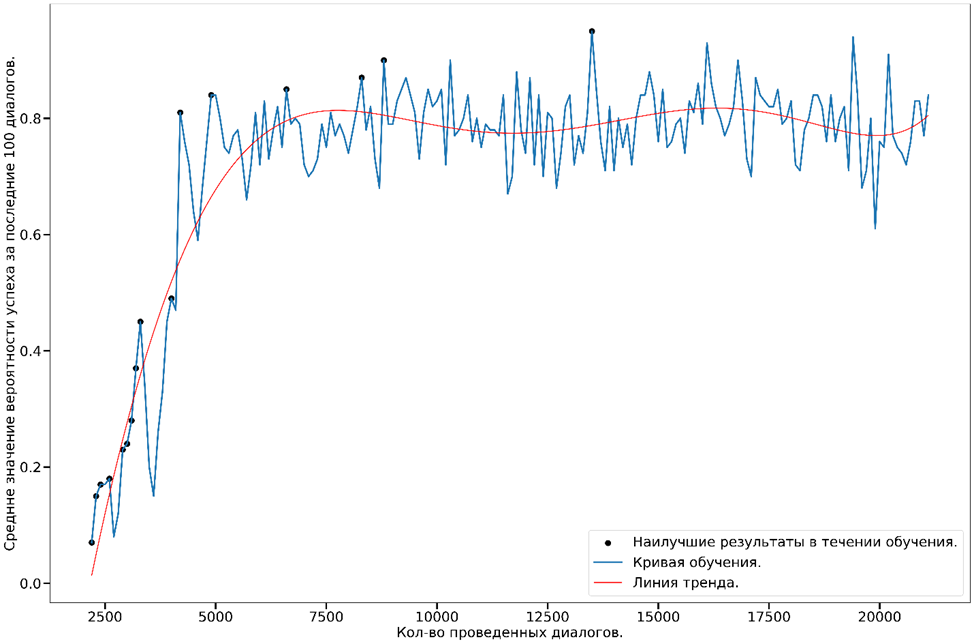

### Кривая обучения алгоритма DDQN.

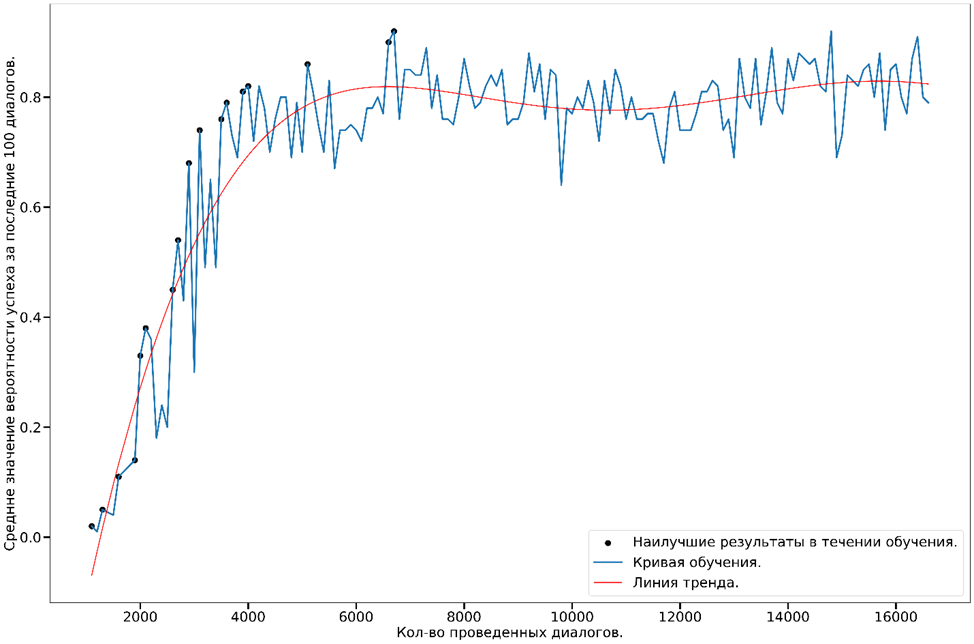

### Сравнение кривых обучений для алгоритмов DQN и DDQN.

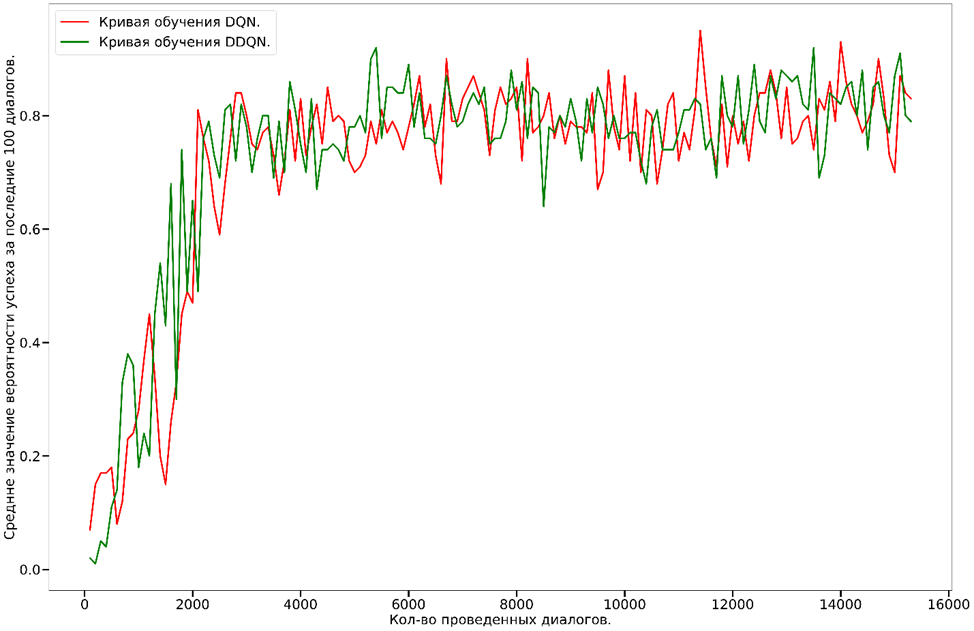